### Description:

We will be using a dataset called **"Economic news article tone and relevance"** from Figure-Eight which consists of approximately 8000 news articles, which were tagged as relevant or not relevant to the US Economy. Our goal in this notebook is to explore the process of training and testing text classifiers for this problem, using this dataset and some text classification algorithms: Naive Bayes, Logistic Regression, Random Forest implemented in sklearn.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
import itertools
import gensim
from gensim.models.word2vec import Word2Vec

Importing the dataset

In [2]:
data = pd.read_csv('Full-Economic-News-DFE-839861.csv', encoding="ISO-8859-1")
data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
0,842613455,False,finalized,3,12/5/15 17:48,3.0,0.6400,yes,0.640,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NaN,NaN,NEW YORK -- Yields on most certificates of dep...
1,842613456,False,finalized,3,12/5/15 16:54,NaN,NaN,no,1.000,wsj_399019502,8/21/07,The Morning Brief: White House Seeks to Limit ...,NaN,NaN,The Wall Street Journal Online</br></br>The Mo...
2,842613457,False,finalized,3,12/5/15 1:59,NaN,NaN,no,1.000,wsj_398284048,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,NaN,NaN,WASHINGTON -- In an effort to achieve banking ...
3,842613458,False,finalized,3,12/5/15 2:19,NaN,0.0000,no,0.675,wsj_397959018,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,NaN,NaN,The statistics on the enormous costs of employ...
4,842613459,False,finalized,3,12/5/15 17:48,3.0,0.3257,yes,0.640,wsj_398838054,10/4/02,Currency Trading: Dollar Remains in Tight Rang...,NaN,NaN,NEW YORK -- Indecision marked the dollar's ton...


In [3]:
data.shape

(8000, 15)

In [4]:
data['relevance'].value_counts()

no          6571
yes         1420
not sure       9
Name: relevance, dtype: int64

In [5]:
data['relevance'].value_counts()/len(data)

no          0.821375
yes         0.177500
not sure    0.001125
Name: relevance, dtype: float64

This is an imbalanced dataset so we have to deal with it accordingly. Most of the observations are not relevant to the US Economy. We will also drop the "not sure" observations. 

In [6]:
data = data[data['relevance'] != "not sure"]
data.shape

(7991, 15)

We only need the "text" and "relevance" columns in the dataset so we will remove the other columns.

In [7]:
data = data[["text","relevance"]]
data.head()

,text,relevance
0,NEW YORK -- Yields on most certificates of dep...,yes
1,The Wall Street Journal Online</br></br>The Mo...,no
2,WASHINGTON -- In an effort to achieve banking ...,no
3,The statistics on the enormous costs of employ...,no
4,NEW YORK -- Indecision marked the dollar's ton...,yes


We need to change the values in the relevence to 0 and 1 since our ML algorithms requires it in that format. 

In [8]:
data['relevance'] = data['relevance'].map({'yes':1, 'no':0}) # 1 corresponds to relevant and 0 to not-relevant

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7991 entries, 0 to 7999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       7991 non-null   object
 1   relevance  7991 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 187.3+ KB


Let's check for duplicates and remove them if any.

In [10]:
data.duplicated().sum()

6

In [11]:
data.drop_duplicates(inplace=True)
data.shape

(7985, 2)

### Text Preprocessing

In [12]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def preprocess(text):
    
    # lowercasing
    text = text.lower()
    
    # removing tags
    pattern = re.compile('<.*?>')
    text = pattern.sub(r'', text)
    
    # remove urls
    pattern = re.compile(r'https?://\S+|www\.\S+')
    text = pattern.sub(r'', text)
    
    # remove punctuations and digits
    text = "".join([ch for ch in text if ch not in string.punctuation and not ch.isdigit()])
    
    # remove stop words
    text = " ".join([w for w in text.split() if w not in ENGLISH_STOP_WORDS])
       
    return text

In [13]:
data['text'] = data['text'].apply(preprocess)

In [14]:
data.head()

,text,relevance
0,new york yields certificates deposit offered m...,1
1,wall street journal onlinethe morning brief lo...,0
2,washington effort achieve banking reform senat...,0
3,statistics enormous costs employee drug abuse ...,0
4,new york indecision marked dollars tone trader...,1


### Modeling

Split data into training and test datasets

In [15]:
X = data['text']
y = data['relevance'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=40)
print(X_train.shape, X_test.shape)

(6388,) (1597,)


We will first use **Bag of Words (BoW)**

In [16]:
cv = CountVectorizer()
X_train_bow = cv.fit_transform(X_train).toarray()
X_test_bow = cv.transform(X_test).toarray()

In [17]:
X_train_bow.shape, X_test_bow.shape

((6388, 61168), (1597, 61168))

The dimension of our feature vector is 61580

Let's use **Multinimial Naive Bayes** first

In [18]:
nb = MultinomialNB()
nb.fit(X_train_bow, y_train)

MultinomialNB()

In [19]:
y_preds = nb.predict(X_test_bow)
print("Model Accuracy:", accuracy_score(y_test, y_preds))
y_pred_prob = nb.predict_proba(X_test_bow)[:, 1]
print("ROC_AUC score:", roc_auc_score(y_test, y_pred_prob))
confusion_matrix(y_test, y_preds)

Model Accuracy: 0.7946149029430182
ROC_AUC score: 0.7304353539362604


array([[1179,  134],
       [ 194,   90]], dtype=int64)

Now we will run a loop to check the performances when we vary the number of max_features (restrict the no. of features to be used)

In [20]:
for N in range(1000, 21000, 1000):

    cv = CountVectorizer(max_features=N)
    X_train_bow = cv.fit_transform(X_train).toarray()
    X_test_bow = cv.transform(X_test).toarray()

    nb = MultinomialNB()
    nb.fit(X_train_bow, y_train)

    y_preds = nb.predict(X_test_bow)
    #print("Model Accuracy:", accuracy_score(y_test, y_preds))
    y_pred_prob = nb.predict_proba(X_test_bow)[:, 1]
    print("ROC_AUC score:", round(roc_auc_score(y_test, y_pred_prob),4), "For N =", N)
    confusion_matrix(y_test, y_preds)

ROC_AUC score: 0.7287 For N = 1000
ROC_AUC score: 0.7389 For N = 2000
ROC_AUC score: 0.7418 For N = 3000
ROC_AUC score: 0.742 For N = 4000
ROC_AUC score: 0.7446 For N = 5000
ROC_AUC score: 0.7456 For N = 6000
ROC_AUC score: 0.7456 For N = 7000
ROC_AUC score: 0.746 For N = 8000
ROC_AUC score: 0.7461 For N = 9000
ROC_AUC score: 0.7467 For N = 10000
ROC_AUC score: 0.7462 For N = 11000
ROC_AUC score: 0.7462 For N = 12000
ROC_AUC score: 0.7462 For N = 13000
ROC_AUC score: 0.7463 For N = 14000
ROC_AUC score: 0.7462 For N = 15000
ROC_AUC score: 0.7461 For N = 16000
ROC_AUC score: 0.7463 For N = 17000
ROC_AUC score: 0.7457 For N = 18000
ROC_AUC score: 0.7448 For N = 19000
ROC_AUC score: 0.7441 For N = 20000


Clearly, max_features of 10000 is the best here

In [21]:
# Re-train with best max_feature value

cv = CountVectorizer(max_features=10000)
X_train_bow = cv.fit_transform(X_train).toarray()
X_test_bow = cv.transform(X_test).toarray()

nb = MultinomialNB()
nb.fit(X_train_bow, y_train)

y_preds = nb.predict(X_test_bow)
print("Model Accuracy:", round(accuracy_score(y_test, y_preds),4))
y_pred_prob = nb.predict_proba(X_test_bow)[:, 1]
print("ROC_AUC score:", round(roc_auc_score(y_test, y_pred_prob),4))
confusion_matrix(y_test, y_preds)

Model Accuracy: 0.6938
ROC_AUC score: 0.7467


array([[915, 398],
       [ 91, 193]], dtype=int64)

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Paired):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)

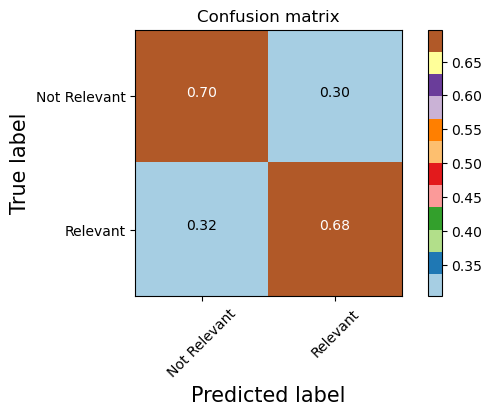

In [23]:
# print the confusion matrix

cnf_matrix = confusion_matrix(y_test, y_preds)
plt.figure(figsize=(6,4))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'], normalize=True,
                      title='Confusion matrix')

Let's try **Logistic Regression** now

Model Accuracy: 0.7439
ROC_AUC score: 0.7467
Confusion Matrix
 [[1079  234]
 [ 175  109]]


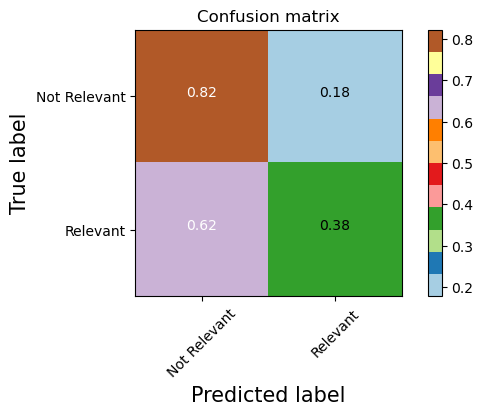

In [24]:
lr = LogisticRegression(class_weight='balanced')  # For imbalanced dataset
lr.fit(X_train_bow, y_train)

y_preds = lr.predict(X_test_bow)
print("Model Accuracy:", round(accuracy_score(y_test, y_preds),4))
y_pred_prob = nb.predict_proba(X_test_bow)[:, 1]
print("ROC_AUC score:", round(roc_auc_score(y_test, y_pred_prob),4))
print("Confusion Matrix\n", confusion_matrix(y_test, y_preds))

cnf_matrix = confusion_matrix(y_test, y_preds)
plt.figure(figsize=(6,4))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'], normalize=True,
                      title='Confusion matrix')

Let's try balancing the training dataset using **SMOTE technique** and then apply Logistic Regression

In [25]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_tr_bal, y_tr_bal = smote.fit_resample(X_train_bow, y_train)

Model Accuracy: 0.737
ROC_AUC score: 0.7467
Confusion Matrix
 [[1088  225]
 [ 195   89]]


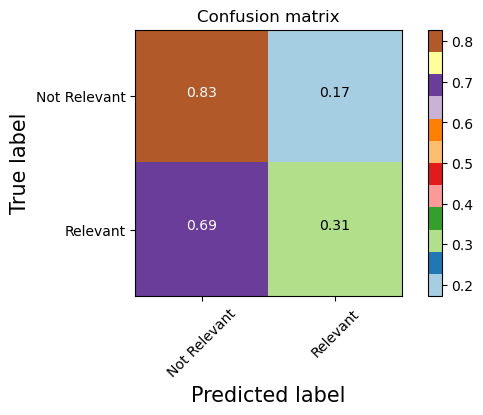

In [26]:
lr = LogisticRegression()
lr.fit(X_tr_bal, y_tr_bal)

y_preds = lr.predict(X_test_bow)
print("Model Accuracy:", round(accuracy_score(y_test, y_preds),4))
y_pred_prob = nb.predict_proba(X_test_bow)[:, 1]
print("ROC_AUC score:", round(roc_auc_score(y_test, y_pred_prob),4))
print("Confusion Matrix\n", confusion_matrix(y_test, y_preds))

cnf_matrix = confusion_matrix(y_test, y_preds)
plt.figure(figsize=(6,4))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'], normalize=True,
                      title='Confusion matrix')

Performance hasn't improved with SMOTE technique

Let's try balancing the training dataset using SMOTE technique and then apply Multinomila Naive Bayes

Model Accuracy: 0.7188
ROC_AUC score: 0.7396


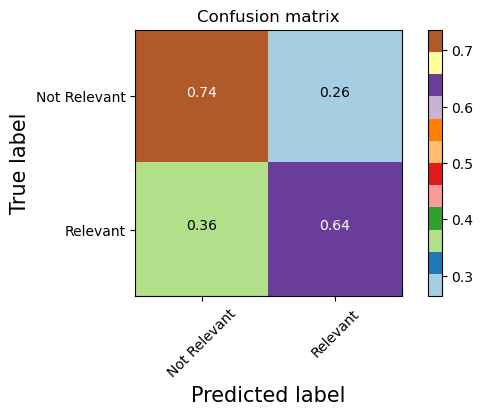

In [27]:
cv = CountVectorizer(max_features=10000)
X_train_bow = cv.fit_transform(X_train).toarray()
X_test_bow = cv.transform(X_test).toarray()

smote = SMOTE()
X_tr_bal, y_tr_bal = smote.fit_resample(X_train_bow, y_train)

nb = MultinomialNB()
nb.fit(X_tr_bal, y_tr_bal)

y_preds = nb.predict(X_test_bow)
print("Model Accuracy:", round(accuracy_score(y_test, y_preds),4))
y_pred_prob = nb.predict_proba(X_test_bow)[:, 1]
print("ROC_AUC score:", round(roc_auc_score(y_test, y_pred_prob),4))
confusion_matrix(y_test, y_preds)

cnf_matrix = confusion_matrix(y_test, y_preds)
plt.figure(figsize=(6,4))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'], normalize=True,
                      title='Confusion matrix')

Let's try **TF-IDF** now

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfifd = TfidfVectorizer()
X_train_tfidf = tfifd.fit_transform(X_train).toarray()
X_test_tfidf = tfifd.transform(X_test).toarray()

Model Accuracy: 0.8222
ROC_AUC score: 0.5907
[[1313    0]
 [ 284    0]]


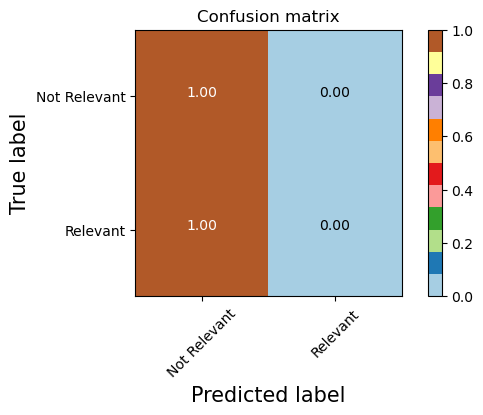

In [29]:
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

y_preds = nb.predict(X_test_tfidf)
print("Model Accuracy:", round(accuracy_score(y_test, y_preds),4))
y_pred_prob = nb.predict_proba(X_test_tfidf)[:, 1]
print("ROC_AUC score:", round(roc_auc_score(y_test, y_pred_prob),4))
print(confusion_matrix(y_test, y_preds))

cnf_matrix = confusion_matrix(y_test, y_preds)
plt.figure(figsize=(6,4))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'], normalize=True,
                      title='Confusion matrix')

This was just a try-out. Clearly, TF-IDF is performing poorly since it's unable to identify the Positive class(Minority class) at all.

Let's try **Word2Vec** now

We will first use a pre-trained Word2Vec embeddings

In [30]:
import gensim.downloader as api
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


We will use 'word2vec-google-news-300'

In [31]:
#w2v = api.load('word2vec-google-news-300')
#type(w2v)

In [32]:
#w2v.save('vectors.kv')

In [33]:
#w2v['apple'][:10]

In [34]:
from gensim.models import KeyedVectors
wv = KeyedVectors.load('vectors.kv')

In [35]:
def sent_vectorizer(sentence):
        
    vector_size = wv.vector_size
    sent_vec = np.zeros(vector_size)
    
    # Sentence vector will be mean of all the vectors of the words in the sentence 
    
    num_words = 1
    for w in sentence.split():
        if w in wv:
            num_words += 1
            sent_vec += wv[w]
    sent_vec = sent_vec/num_words
    
    return sent_vec

In [36]:
data['vectors'] = data['text'].apply(sent_vectorizer)

In [37]:
data.head()

,text,relevance,vectors
0,new york yields certificates deposit offered m...,1,"[0.005566847951788651, 0.02144562570672286, -0..."
1,wall street journal onlinethe morning brief lo...,0,"[-0.02102912976903823, 0.02582801892919448, 0...."
2,washington effort achieve banking reform senat...,0,"[-0.012113263530115928, 0.07731800694619456, -..."
3,statistics enormous costs employee drug abuse ...,0,"[-0.04654400758068971, 0.0471238030327691, 0.0..."
4,new york indecision marked dollars tone trader...,1,"[-0.01678413084183616, 0.0039674605446300285, ..."


In [38]:
X = data['vectors'].to_list()
y = data['relevance'].to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=40)

Model Accuracy: 0.6625
ROC_AUC score: 0.7322


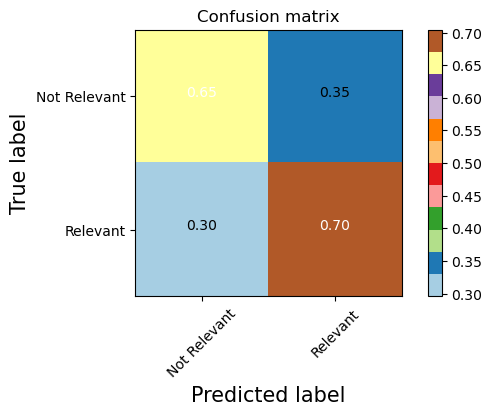

In [39]:
clf = GaussianNB()
clf.fit(X_train, y_train)
gaussian_nb = clf
y_preds = clf.predict(X_test)
print("Model Accuracy:", round(accuracy_score(y_test, y_preds),4))
y_pred_prob = clf.predict_proba(X_test)[:, 1]
print("ROC_AUC score:", round(roc_auc_score(y_test, y_pred_prob),4))
confusion_matrix(y_test, y_preds)

cnf_matrix = confusion_matrix(y_test, y_preds)
plt.figure(figsize=(6,4))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'], normalize=True,
                      title='Confusion matrix')

Model Accuracy: 0.7013
ROC_AUC score: 0.7594


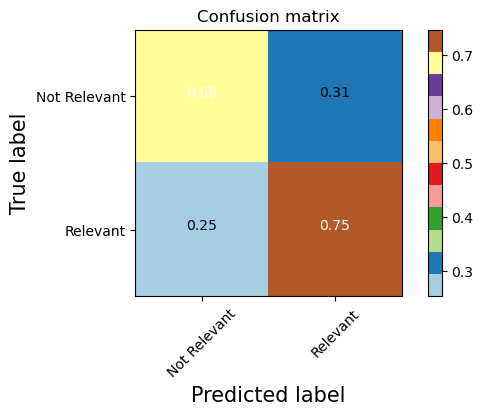

In [40]:
clf = LogisticRegression(class_weight='balanced')
clf.fit(X_train, y_train)
log_reg = clf

y_preds = clf.predict(X_test)
print("Model Accuracy:", round(accuracy_score(y_test, y_preds),4))
y_pred_prob = clf.predict_proba(X_test)[:, 1]
print("ROC_AUC score:", round(roc_auc_score(y_test, y_pred_prob),4))
confusion_matrix(y_test, y_preds)

cnf_matrix = confusion_matrix(y_test, y_preds)
plt.figure(figsize=(6,4))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'], normalize=True,
                      title='Confusion matrix')

Applying the classifier on some random sentences to check

In [41]:
# Let's see how it predicts on some given sentences

def make_ready_for_model(text):
    
    text = preprocess(text)
    return sent_vectorizer(text)

In [42]:
texts = ["Is the FED going to hike interest rates now?",
         "This is an amazing pizza from my favourite restaurant!",
         "A stock market crash is coming in the NYSE",
         "I am just fooling around.",
         "US economy is going to do well in the next quarter.",
         "Who let the dogs out!!"
        ]   

for text in texts:
    
    print("News:", text)
    text_vec = make_ready_for_model(text)
    
    for clf, mod in [(gaussian_nb,"Gaussian Naive Bayes"), (log_reg,"Logistic Regression")]:        
        print(mod,'Prediction: Relevant') if int(clf.predict([text_vec])) else print(mod,'Prediction: Not Relevant')
    print("\n")

News: Is the FED going to hike interest rates now?
Gaussian Naive Bayes Prediction: Not Relevant
Logistic Regression Prediction: Relevant


News: This is an amazing pizza from my favourite restaurant!
Gaussian Naive Bayes Prediction: Not Relevant
Logistic Regression Prediction: Not Relevant


News: A stock market crash is coming in the NYSE
Gaussian Naive Bayes Prediction: Not Relevant
Logistic Regression Prediction: Relevant


News: I am just fooling around.
Gaussian Naive Bayes Prediction: Not Relevant
Logistic Regression Prediction: Not Relevant


News: US economy is going to do well in the next quarter.
Gaussian Naive Bayes Prediction: Not Relevant
Logistic Regression Prediction: Relevant


News: Who let the dogs out!!
Gaussian Naive Bayes Prediction: Not Relevant
Logistic Regression Prediction: Not Relevant




Naive Bayes is not performing well with the Minority Class but Logistic Regression is able to classify all correctly!

Now we will train **our own Word2Vec embeddings**

In [43]:
from nltk import sent_tokenize
from gensim.utils import simple_preprocess

In [44]:
texts = []
for doc in data['text']:
    
    raw_sent = sent_tokenize(doc)
    for sent in raw_sent:
        texts.append(simple_preprocess(sent))    

In [45]:
model = Word2Vec(window=10, min_count=2)
model.build_vocab(texts)
model.train(texts, total_examples=model.corpus_count, epochs=model.epochs)

(4347595, 4661235)

In [46]:
len(model.wv.index_to_key) # No. of words in the vocabulary

27581

In [47]:
def document_vector(doc):
    
    doc = [word for word in doc.split() if word in model.wv.index_to_key]
    return np.mean(model.wv[doc], axis=0)

In [48]:
from tqdm import tqdm

X = []
for doc in tqdm(data['text'].values):
    X.append(document_vector(doc))

100%|██████████████████████████████████████████████████████████████████████████████| 7985/7985 [03:15<00:00, 40.86it/s]


In [49]:
X = np.array(X)
y = data['relevance'].values

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=40)
print(X_train.shape, X_test.shape)

(6388, 100) (1597, 100)


Model Accuracy: 0.6738
ROC_AUC score: 0.734


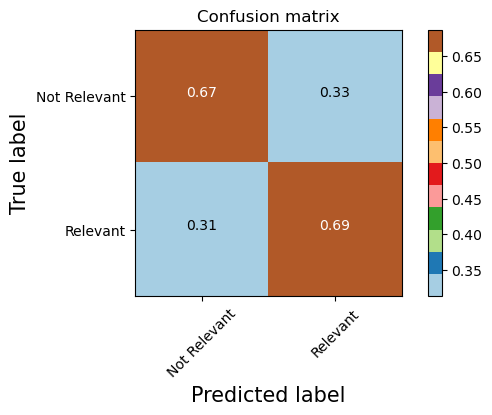

In [51]:
# Let's try Gaussian Naive Bayes first

clf = GaussianNB()
clf.fit(X_train, y_train)
gaussian_nb = clf

y_preds = clf.predict(X_test)
print("Model Accuracy:", round(accuracy_score(y_test, y_preds),4))
y_pred_prob = clf.predict_proba(X_test)[:, 1]
print("ROC_AUC score:", round(roc_auc_score(y_test, y_pred_prob),4))
confusion_matrix(y_test, y_preds)

cnf_matrix = confusion_matrix(y_test, y_preds)
plt.figure(figsize=(6,4))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'], normalize=True,
                      title='Confusion matrix')

Model Accuracy: 0.6957
ROC_AUC score: 0.7479


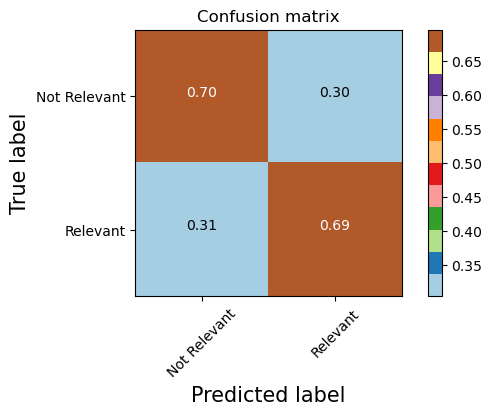

In [52]:
# Let's try Logistic Regression now

clf = LogisticRegression(class_weight='balanced')
clf.fit(X_train, y_train)
log_reg = clf

y_preds = clf.predict(X_test)
print("Model Accuracy:", round(accuracy_score(y_test, y_preds),4))
y_pred_prob = clf.predict_proba(X_test)[:, 1]
print("ROC_AUC score:", round(roc_auc_score(y_test, y_pred_prob),4))
confusion_matrix(y_test, y_preds)

cnf_matrix = confusion_matrix(y_test, y_preds)
plt.figure(figsize=(6,4))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'], normalize=True,
                      title='Confusion matrix')

In [53]:
# Let's try out predictions over the new model

def make_ready_for_model2(text):
    
    text = preprocess(text)
    return document_vector(text)

texts = ["Is the FED going to hike interest rates now?",
         "This is an amazing pizza from my favourite restaurant!",
         "A stock market crash is coming in the NYSE",
         "I am just fooling around.",
         "US economy is going to do well in the next quarter.",
         "Who let the dogs out!!"
        ]   

for text in texts:
    
    print("News:", text)
    text_vec = make_ready_for_model2(text)
    
    for clf, mod in [(gaussian_nb,"Gaussian Naive Bayes"), (log_reg,"Logistic Regression")]:        
        print(mod,'Prediction: Relevant') if int(clf.predict([text_vec])) else print(mod,'Prediction: Not Relevant')
    print("\n")

News: Is the FED going to hike interest rates now?
Gaussian Naive Bayes Prediction: Relevant
Logistic Regression Prediction: Relevant


News: This is an amazing pizza from my favourite restaurant!
Gaussian Naive Bayes Prediction: Not Relevant
Logistic Regression Prediction: Not Relevant


News: A stock market crash is coming in the NYSE
Gaussian Naive Bayes Prediction: Relevant
Logistic Regression Prediction: Not Relevant


News: I am just fooling around.
Gaussian Naive Bayes Prediction: Relevant
Logistic Regression Prediction: Not Relevant


News: US economy is going to do well in the next quarter.
Gaussian Naive Bayes Prediction: Relevant
Logistic Regression Prediction: Relevant


News: Who let the dogs out!!
Gaussian Naive Bayes Prediction: Not Relevant
Logistic Regression Prediction: Not Relevant




**Out of all the models that we have trained, clearly, Logistic Regression model trained with the pre-trained Word2Vec embeddings has the best Test dataset AUC score of 0.7594**